In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import average_precision_score
from scipy.stats import expon
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import nn
import torch.nn.functional as F

from autoencoder import AutoEncoder
from fin_anomaly_modules import add_noise

%load_ext autoreload
%autoreload 2

### Define the experimental parameters and set seed

In [2]:
# define global experiment parameters
exp_params = dict(

    seed = 111, # random seed
    batch_size = 512, # batch size   

    encoder_layers = [512, 256], # encoder layers
    decoder_layers = [256, 512], # decoder layers
    learning_rate = 1e-4, # learning rate
    activation = 'lrelu', # activation function
    epochs = 500, # number of epochs

    # set device, either 'cuda' or 'cpu'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
)
    
# set seed
rng = np.random.default_rng(exp_params['seed']) # set numpy seed
torch.manual_seed(exp_params['seed'])  # set pytorch seed CPU
torch.cuda.manual_seed(exp_params['seed'])  # set pytorch seed GPU

### Download Credit Default Dataset

In [3]:
# fetch Credit Default dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 
  
# variable information 
vars = default_of_credit_card_clients.variables
vars_map = dict(zip(vars['name'], vars['description']))


### Define the categorical and numeric attributes

In [4]:
# rename columns
X.rename(columns=vars_map, inplace=True)

# set numerical and categorical attributes
numerical_attributes = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                        'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'LIMIT_BAL']
numerical_attributes_scaled = [num_attr + '_SCALED' for num_attr in numerical_attributes]
categorical_attributes = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# set string type for categorical attributes
X[categorical_attributes] = X[categorical_attributes].astype(str)
X[numerical_attributes] = X[numerical_attributes].astype(float)

/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_62209/2037472979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=vars_map, inplace=True)
/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_62209/2037472979.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_attributes] = X[categorical_attributes].astype(str)
/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_62209/2037472979.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### Data Transformation: 
- categorical using one-hot
- numeric uning standard scaler

In [5]:
# one-hot encode categorical attributes
cat_encoder = OneHotEncoder(sparse_output=False)
# fit categorical attributes of clean data
cat_encoder.fit(X[categorical_attributes])
# transform categorical attributes of clean train and test data
X_train_cat = cat_encoder.transform(X[categorical_attributes])

# scale numerical attributes
num_scaler = StandardScaler()
# fit numerical attributes of clean train data
num_scaler.fit(X[numerical_attributes])
# transform numerical attributes of clean train and test data
X_train_num = num_scaler.transform(X[numerical_attributes])

# combine numerical and categorical attributes
X_train_encoded = np.concatenate([X_train_cat, X_train_num], axis=1)
print(f"Train data shape: {X_train_encoded.shape}")

Train data shape: (30000, 146)


### Build metadata for categorical attributes

In [6]:
# collect positions of transformed numerical attributes
num_attr_positions = list(range(X_train_cat.shape[1], X_train_encoded.shape[1]))
num_attr_positions = dict(zip(numerical_attributes, num_attr_positions))

# collect positions of transformed categorical attributes
cat_attr_positions = dict()
one_hot_cols = cat_encoder.get_feature_names_out()
for _, cat_attr in enumerate(categorical_attributes):
    # get index of categorical attributes
    idx = [i for i, s in enumerate(one_hot_cols) if s.startswith(cat_attr)]
    # store index of categorical attributes
    cat_attr_positions[cat_attr] = idx

cat_metadata = dict(
    encoder = cat_encoder,
    attributes = categorical_attributes,
    idx_position = cat_attr_positions
)

# collect positions of transformed numerical attributes
num_metadata = dict(
    scaler = num_scaler,
    attributes = numerical_attributes,
    idx_position = num_attr_positions
)

### Initialize training settings, define loss functions, optimizer and Dataloader

In [7]:
# convert to tensor
X_train_torch = torch.Tensor(X_train_encoded)

# set input dimension
input_dim = X_train_torch.shape[1]

### initialize model

dataloader = DataLoader(dataset=X_train_torch, batch_size=exp_params['batch_size'], shuffle=True)

# build autoencoder model
model = AutoEncoder([input_dim, *exp_params['encoder_layers']], [*exp_params['decoder_layers'], input_dim]).to(exp_params['device'])


# init encoder optimizer
optimizer = optim.Adam(model.parameters(), lr=exp_params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=exp_params['epochs'], verbose=True)

# init autoencoder losses
reconstruction_BCE = nn.CrossEntropyLoss(reduction='none').to(exp_params['device'])
reconstruction_MSE = nn.MSELoss(reduction='none').to(exp_params['device'])

/Users/timur/Documents/Projects/21_DFKI_BuBa_Explainable_AE/graphem/team/Timur/Explainable_Autoencoder/06_github_code/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# Start training

In [8]:
device = exp_params['device']
################## start training ########################

rec_errors_epoch_bce = []
rec_errors_epoch_mse = []
rec_errors_epoch_total = []

# iterate over distinct training epochs
pbar = tqdm(iterable=range(exp_params['epochs']))
for i in pbar:
    # init rec errors
    rec_errors_batch_bce = []
    rec_errors_batch_mse = []
    rec_errors_batch_total = []

    # iterate over distinct minibatches
    for batch_id, batch_clean in enumerate(dataloader):

        # add noise to batch
        batch_noise = add_noise(
            clean_data=batch_clean, 
            cat_features=categorical_attributes,
            num_features=numerical_attributes, 
            cat_attr_positions=cat_metadata['idx_position'],
            num_attr_positions=num_metadata['idx_position'],
            pct_outliers=0.03, 
            rng=rng,
            num_noise_max_fraction=0.5, 
            cat_noise_max_fraction=0.5
        )

        # set network in training mode
        model.train()
        model.to(device)

        # move to device
        batch_noise = batch_noise.to(device)
        batch_clean = batch_clean.to(device)

        # reset encoder and decoder gradients
        optimizer.zero_grad()

        # conduct forward encoder/decoder pass
        rec_batch, z_batch = model(batch_noise)

        # init rec loss
        rec_error_batch_bce = torch.zeros(batch_noise.shape[0]).to(device)
        rec_error_batch_mse = torch.zeros(batch_noise.shape[0]).to(device)

        for cat_attr in categorical_attributes:
            # get attribute of reconstruction and input batch
            rec_batch_cat_attr = rec_batch[:, cat_attr_positions[cat_attr]]
            batch_clean_cat_attr = batch_clean[:, cat_attr_positions[cat_attr]]
            batch_noise_cat_attr = batch_noise[:, cat_attr_positions[cat_attr]]
            # compute reconstruction error of categorical attributes
            rec_error_batch_bce_single_attr = reconstruction_BCE(input=rec_batch_cat_attr,
                                                                 target=batch_clean_cat_attr.argmax(axis=1))
            # add categorical losses
            rec_error_batch_bce += rec_error_batch_bce_single_attr

        for num_attr in numerical_attributes:
            # get attribute of reconstruction and input batch
            rec_batch_num_attr = rec_batch[:, num_attr_positions[num_attr]]
            batch_clean_num_attr = batch_clean[:, num_attr_positions[num_attr]]
            batch_noise_num_attr = batch_noise[:, num_attr_positions[num_attr]]
            # compute reconstruction error of numeric attributes
            rec_error_batch_mse_single_attr = reconstruction_MSE(input=rec_batch_num_attr,
                                                    target=batch_clean_num_attr)

            rec_error_batch_mse += rec_error_batch_mse_single_attr

        # compute total reconstruction error
        rec_error_batch = rec_error_batch_bce + rec_error_batch_mse
        rec_error_batch_mean = rec_error_batch.mean()
        rec_error_batch_bce_mean = rec_error_batch_bce.mean()
        rec_error_batch_mse_mean = rec_error_batch_mse.mean()

        # run error back-propagation
        rec_error_batch_mean.backward()

        # optimize encoder and decoder parameters
        optimizer.step()

        # collect rec errors of a single batch
        rec_errors_batch_bce.append(rec_error_batch_bce_mean.item())
        rec_errors_batch_mse.append(rec_error_batch_mse_mean.item())
        rec_errors_batch_total.append(rec_error_batch_mean.item())

    # average rec errors of multiple batches
    rec_errors_bce_mean = np.mean(rec_errors_batch_bce)
    rec_errors_mse_mean = np.mean(rec_errors_batch_mse)
    rec_errors_mean = np.mean(rec_errors_batch_total)

    # collect rec errors of epoch
    rec_errors_epoch_bce.append(rec_errors_bce_mean)
    rec_errors_epoch_mse.append(rec_errors_mse_mean)
    rec_errors_epoch_total.append(rec_errors_mean)

    # update learning rate according to the scheduler
    scheduler.step()
 
    # update progress bar
    pbar.set_description(f"Autoencoder Reconstruction Loss TRAIN SET: (BCE): {rec_errors_bce_mean:.4f} (MSE): {rec_errors_mse_mean:.4f} TOTAL: {rec_errors_mean:.4f}")


Autoencoder Reconstruction Loss TRAIN SET: (BCE): 0.2413 (MSE): 0.1764 TOTAL: 0.4177: 100%|██████████| 500/500 [06:27<00:00,  1.29it/s]


### Plot reconstruction error loss, separately for categorical, numeric and total

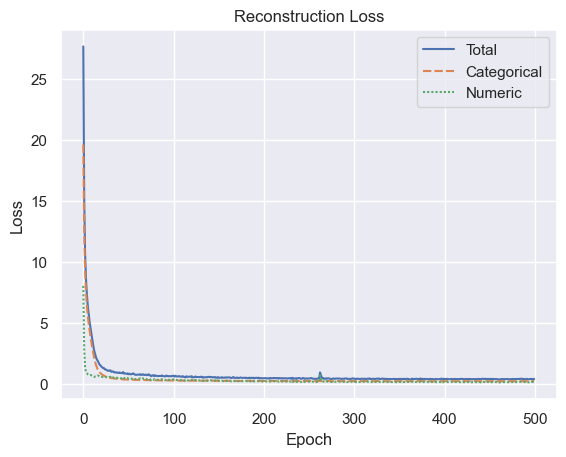

In [9]:
sns.set_theme()
rec_errors_df = pd.concat([pd.Series(rec_errors_epoch_total), pd.Series(rec_errors_epoch_bce), pd.Series(rec_errors_epoch_mse)], axis=1)
rec_errors_df.columns = ['Total', 'Categorical', 'Numeric']
sns.lineplot(data=rec_errors_df);
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation

In [10]:
# perform evaluation of the model on the test set
model.eval()

# forward pass of test set
rec_train, z_test = model(X_train_torch.to(device))

# move to cpu
# rec_test = rec_test.detach().cpu().numpy()

# emtpy dataframe to store rec errors
rec_error_train_df = pd.DataFrame()


### Compute reconstuction losses for categorical and numeric attributes

In [11]:

# compute rec loss of cat & num attributes
for cat_attr in categorical_attributes:
    # get attribute of reconstruction and input batch
    rec_train_cat_attr = rec_train[:, cat_attr_positions[cat_attr]]
    train_cat_attr = X_train_torch[:, cat_attr_positions[cat_attr]]
    # compute reconstruction error of categorical attributes
    rec_error_train_bce_single_attr = reconstruction_BCE(input=rec_train_cat_attr,
                                                            target=train_cat_attr.argmax(axis=1))
    
    # add rec errors to dataframe
    rec_error_train_df[cat_attr] = rec_error_train_bce_single_attr.detach().cpu().numpy()

for num_attr in numerical_attributes:
    # get attribute of reconstruction and input batch
    rec_train_num_attr = rec_train[:, num_attr_positions[num_attr]]
    train_num_attr = X_train_torch[:, num_attr_positions[num_attr]]

    # compute reconstruction error of numeric attributes
    rec_error_train_mse_single_attr = reconstruction_MSE(input=rec_train_num_attr,
                                        target=train_num_attr)

    # add rec errors to dataframe
    rec_error_train_df[num_attr] = rec_error_train_mse_single_attr.detach().cpu().numpy()

# compute rec loss of cat & num attributes
rec_loss_train_cat = rec_error_train_df[categorical_attributes].sum(axis=1) 
rec_loss_train_num = rec_error_train_df[numerical_attributes].sum(axis=1)

# total loss
total_loss_train = rec_loss_train_cat + rec_loss_train_num

print(f"Autoencoder Reconstruction Loss TEST SET: (BCE): {rec_errors_bce_mean:.4f} (MSE): {rec_errors_mse_mean:.4f} TOTAL: {rec_errors_mean:.4f}")

Autoencoder Reconstruction Loss TEST SET: (BCE): 0.2413 (MSE): 0.1764 TOTAL: 0.4177


### Compute softmax of categorical reconstructions

In [12]:
# 1. compute softmax of categorical reconstructions
rec_softmax_df = pd.DataFrame(index=rec_error_train_df.index, columns=one_hot_cols)

for cat_attr in categorical_attributes:
    # get index of cat attribute
    cat_attr_idx = cat_attr_positions[cat_attr]    
    # get attribute of categorcial reconstruction 
    rec_test_cat_attr = rec_train[:, cat_attr_idx]
    # compute softmax of categorical reconstructions
    rec_softmax = F.softmax(rec_test_cat_attr, dim=1)
    # add softmax to dataframe
    rec_softmax_df.iloc[:, cat_attr_idx] = rec_softmax.detach().cpu().numpy()

### Compute expected values 

In [13]:
# 2. compute expected values 
expected_values_df = pd.DataFrame(index=rec_error_train_df.index)
expected_values_tmp_df = pd.DataFrame(index=rec_error_train_df.index, columns=one_hot_cols)

# Define a function to round softmax scores to [0,1] values
def round_softmax_scores(row):
    max_score = row.max()
    return [1 if x == max_score else 0 for x in row]


for cat_attr in categorical_attributes:
    # get index of cat attribute
    cat_attr_idx = cat_attr_positions[cat_attr]    

    # get softmax of categorical reconstructions
    rec_softmax_single_attr = rec_softmax_df.iloc[:, cat_attr_idx]

    # Apply the function to each row of the DataFrame
    rounded_scores = rec_softmax_single_attr.apply(round_softmax_scores, axis=1, result_type='expand')

    # Add the rounded scores to the DataFrame
    # rec_softmax_df.iloc[:, cat_attr_idx] = rounded_scores
    expected_values_tmp_df.iloc[:, cat_attr_idx] = rounded_scores

# add expected values of categorical attributes
expected_values_df[categorical_attributes] = cat_encoder.inverse_transform(expected_values_tmp_df.values)

# numerical attributes
rec_num_attr = rec_train[:, list(num_attr_positions.values())]

# add expected values of numerical attributes
expected_values_df[numerical_attributes] = num_scaler.inverse_transform(rec_num_attr.detach().cpu().numpy()).round(0)

### Compute probability of error

In [14]:
# 3. compute probability of error
prob_of_error = pd.DataFrame(index=rec_error_train_df.index)

for cat_attr in categorical_attributes:
    # the inverse of the cross-entropy loss
    prob_of_error[cat_attr] = 1.0 - np.exp(-rec_error_train_df[cat_attr]).round(2)


for num_attr in numerical_attributes:
    # transform the mean squared error to the probability
    prob_of_error[num_attr] = expon.cdf(rec_error_train_df[num_attr], scale=1).round(2)

# Get top N anomalies

In [15]:
# get the indices of the largest errors
largest_errors_idx = total_loss_train.sort_values(ascending=False).index

In [16]:
N = 1
# compbine original, expected and prob of error
error_df = pd.concat([X[[*categorical_attributes, *numerical_attributes]].iloc[largest_errors_idx[N]], 
                      expected_values_df.iloc[largest_errors_idx[N]], 
                      prob_of_error.iloc[largest_errors_idx[N]]], axis=1)
error_df.columns = ['Original', 'Expected', 'Prob. of Error']
error_df

,Original,Expected,Prob. of Error
SEX,1,1,0.04
EDUCATION,1,1,0.00
MARRIAGE,2,2,0.00
AGE,33,33,0.05
PAY_0,0,0,0.00
PAY_2,0,0,0.00
PAY_3,0,0,0.00
PAY_4,0,0,0.00
PAY_5,0,0,0.00
PAY_6,0,0,0.00
